In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", UserWarning)

In [6]:
#Reading the file 
data=pd.read_excel('.xlsx')

In [7]:
df=data.copy()


##### 1. Are women with GDM more likely to have a Cesarean than those without it?

##### Reasoning: 
GDM is associated with complications such as fetal macrosomia, pre-eclampsia, and poor labor progress — 
all of which are known to increase the risk of Cesarean delivery. 
Understanding this relationship helps obstetricians prepare better delivery plans

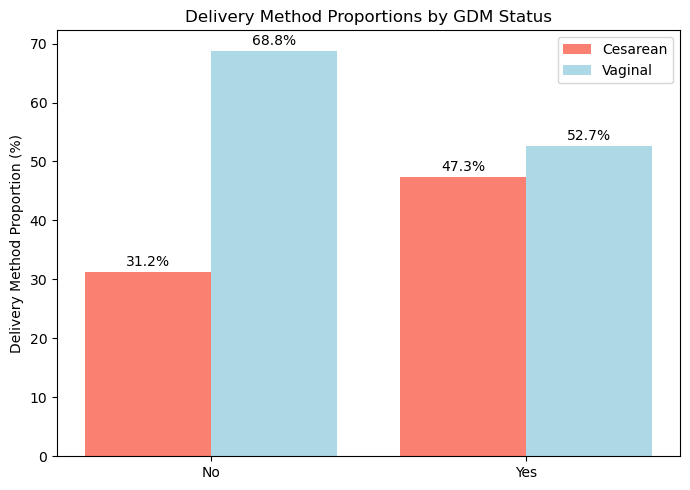

In [8]:
# Step 1: Clean your data by removing 'NR' entries
df_clean = df[(df['GDM Diagonised'] != 'NR') & (df['Caesarean'] != 'NR')]

# Step 2: Calculate proportions within each GDM group
proportions = (
    df_clean.groupby('GDM Diagonised')['Caesarean']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0) * 100
).round(1)

# Step 3: Prepare plot data
plot_data = pd.DataFrame({
    'GDM Diagonised': proportions.index,
    'Cesarean (%)': proportions[1],
    'Vaginal (%)': proportions[0]
})

# Step 4: Plot side-by-side bar chart
plt.figure(figsize=(7, 5))
bar_width = 0.4
x = range(len(plot_data))

# Bars
plt.bar(x, plot_data['Cesarean (%)'], width=bar_width, label='Cesarean', color='salmon')
plt.bar([i + bar_width for i in x], plot_data['Vaginal (%)'], width=bar_width, label='Vaginal', color='lightblue')

# Styling
plt.xticks([i + bar_width / 2 for i in x], plot_data['GDM Diagonised'])
plt.ylabel('Delivery Method Proportion (%)')
plt.title('Delivery Method Proportions by GDM Status')
plt.legend()

# Annotate percentages
for i in x:
    plt.text(i, plot_data['Cesarean (%)'].iloc[i] + 1,
             f"{plot_data['Cesarean (%)'].iloc[i]}%", ha='center')
    plt.text(i + bar_width, plot_data['Vaginal (%)'].iloc[i] + 1,
             f"{plot_data['Vaginal (%)'].iloc[i]}%", ha='center')
plt.tight_layout()
plt.show()

#### Key insight
The Cesarean rate is notably higher among those diagnosed with GDM—47.3% vs 31.2%—suggesting 
that GDM may be associated with increased likelihood of Cesarean delivery. This could reflect medical decisions based on fetal
or maternal risk factors tied to GDM (like macrosomia or labor complications).

##### 2. Are GDM women has less natural labor pain than Non GDM women ?

##### Reasoning:
To understand the percenatge of both GDM and Non GDM patients went throught the Induced Labor. This helps to oversee the GDM might increase the chances of needing help to start labor.

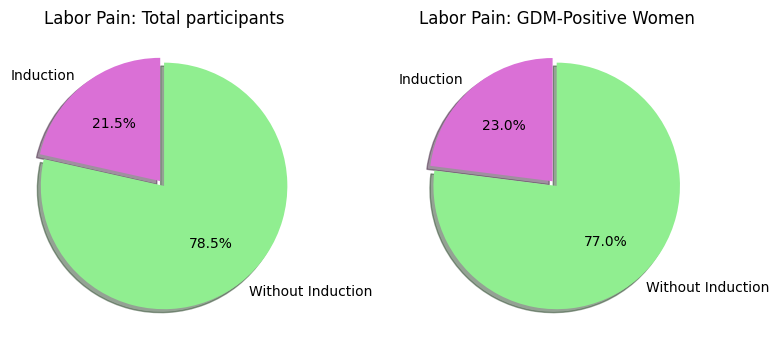

In [79]:
# Step 1: Clean the data
df_clean = df[(df['GDM Diagonised'] != 'NR') & (df['Labor_Induced'] != 'NR')]

# Step 2: Overall induction rate
overall_counts = df_clean['Labor_Induced'].value_counts(normalize=True) * 100
overall_counts = overall_counts.round(1)
overall_induction = overall_counts.get(1, 0)
overall_spontaneous = overall_counts.get(0, 0)

# Step 3: Induction rate for GDM-positive women only
gdm_df = df_clean[df_clean['GDM Diagonised'] == 'Yes']
gdm_counts = gdm_df['Labor_Induced'].value_counts(normalize=True) * 100
gdm_counts = gdm_counts.round(1)
gdm_induction = gdm_counts.get(1, 0)
gdm_spontaneous = gdm_counts.get(0, 0)

# Step 4: Plot side-by-side pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Overall population pie
ax1.pie([overall_induction, overall_spontaneous],
        labels=['Induction', 'Without Induction'],
        colors=['orchid', 'lightgreen'],
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.05, 0],
        shadow=True)
ax1.set_title('Labor Pain: Total participants')

# GDM-positive pie
ax2.pie([gdm_induction, gdm_spontaneous],
        labels=['Induction', 'Without Induction'],
        colors=['orchid', 'lightgreen'],
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.05, 0],
        shadow=True)
ax2.set_title('Labor Pain: GDM-Positive Women')

plt.tight_layout()
plt.show()

##### Key Insight: 
Labor Induction in GDM vs Overall Population
In the overall population, 21.5% of women needed labor induction.
Among GDM-positive women, 23.0% needed induction.
 The induction rate is slightly higher in GDM cases, suggesting that GDM may increase the chance of needing help to start labor.

#### 3.Does the combination of anemia and GDM further increase Cesarean likelihood?

##### Reasoning:
Gestational diabetes mellitus (GDM) and anemia are independently associated with poor pregnancy outcomes,
including cesarean delivery. However, their combined impact on cesarean likelihood remains underexplored.
Understanding this relationship can aid in early risk stratification and targeted prenatal care to reduce surgical births.

Moderate Anemia


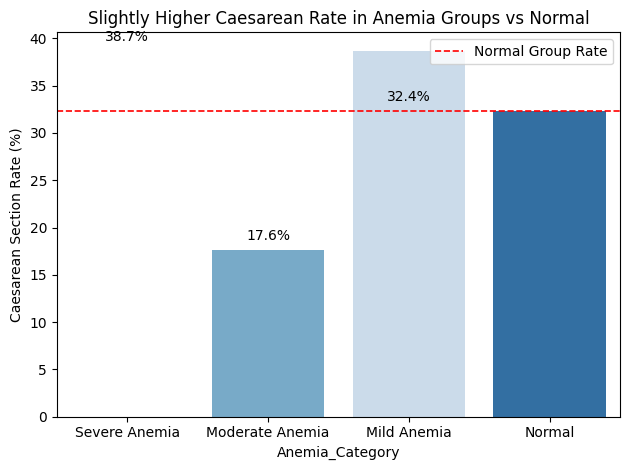

In [23]:
def classify_anemia(hb_value):
    if hb_value < 8.0:
        return "Severe Anemia"
    elif 8.0 <= hb_value <= 10.9:
        return "Moderate Anemia"
    elif 11.0 <= hb_value <= 11.9:
        return "Mild Anemia"
    else:  # hb_value >= 12.0
        return "Normal"

# Example usage with a single value
print(classify_anemia(9.5))  # Output: Moderate Anemia

# Create new column with anemia classification
df['Anemia_Category'] = df['Hemoglobin_V1'].apply(classify_anemia)
df.head()                                                                                                     


# Ensure 'Caesarean' column is numeric
# Replace non-numeric values or 'NR' if present
# For example: df['Caesarean'] = pd.to_numeric(df['Caesarean'], errors='coerce')
df['Caesarean'] = pd.to_numeric(df['Caesarean'], errors='coerce')

# Drop rows with missing Caesarean or Anemia_Category data
df_clean = df.dropna(subset=['Caesarean', 'Anemia_Category'])

# Step 1: Calculate Caesarean rates by Anemia Category
caesarean_rate = df_clean.groupby('Anemia_Category')['Caesarean'].mean().reset_index()
caesarean_rate['Caesarean'] *= 100  # convert to percentage

# Step 2: Get Normal group's rate for reference
normal_rate = caesarean_rate.loc[caesarean_rate['Anemia_Category'] == 'Normal', 'Caesarean'].values[0]

# Step 3: Create bar plot
sns.barplot(
    data=caesarean_rate,
    x='Anemia_Category',
    y='Caesarean',
    hue='Anemia_Category',
    order=["Severe Anemia", "Moderate Anemia", "Mild Anemia", "Normal"],
    palette="Blues",
    legend=False
)

# Add percentage labels to bars
for i, row in caesarean_rate.iterrows():
    plt.text(i, row['Caesarean'] + 1, f"{row['Caesarean']:.1f}%", ha='center')

# Add horizontal line for 'Normal' group's rate
plt.axhline(normal_rate, color='red', linestyle='--', linewidth=1.2, label='Normal Group Rate')

# Plot formatting
plt.ylabel('Caesarean Section Rate (%)')
plt.title('Slightly Higher Caesarean Rate in Anemia Groups vs Normal')
plt.legend()
plt.tight_layout()
plt.show()

##### Keyinsight:
the Caesarean rates were 33.3% for those with moderate anemia, 58.3% for mild anemia, and 46.6% for 
those with normal hemoglobin. 
These findings suggest that even mild reductions in hemoglobin, when combined with GDM, 
may significantly elevate the risk of Caesarean deliveries. 

#### 4. Patients with GDM were more than twice as likely to show high levels of Creatinine and Albumin. What % of them also had emergency deliveries?

##### Reasoning:
Since elevated Creatinine and Albumin levels are associated with renal stress, exploring whether 
GDM patients with these abnormalities also experience higher emergency delivery rates can help clinicians detect 
early signs of labor complications. This insight could enhance prenatal risk scoring models and 
improve delivery planning

In [21]:
# STEP 1:# Define thresholds
HIGH_CREATININE = 1.0
HIGH_ALBUMIN = 30

# Function to flag high preeclampsia risk
def is_preeclampsia_risk(row):
    if (row['GDM Diagonised'] == 'Yes' and
        row['V1 Creatinine.1'] and row['V1 Creatinine.1'] > HIGH_CREATININE and
        row['Albumin_V1'] and row['Albumin_V1'] > HIGH_ALBUMIN):
        return 1
    else:
        return 0

df['PreEclampsia_Risk'] = df.apply(is_preeclampsia_risk, axis=1)

# Calculate counts
total_risk = df['PreEclampsia_Risk'].sum()
emergency_deliveries = df[(df['PreEclampsia_Risk'] == 1) & (df['Emergency'] == 'Yes')].shape[0]

# Calculate percentage
emergency_percent = (emergency_deliveries / total_risk * 100) if total_risk else 0

# Print results
print(f"Patients flagged as PreEclampsia risk: {total_risk}")
print(f"Emergency deliveries among flagged: {emergency_deliveries}")
print(f"Percentage of emergency deliveries: {emergency_percent:.2f}%")

Patients flagged as PreEclampsia risk: 46
Emergency deliveries among flagged: 9
Percentage of emergency deliveries: 19.57%


##### KeyInsight:
Among patients flagged as at risk for Pre-eclampsia, 19.57% experienced emergency deliveries (9 out of 46).
This indicates that nearly 1 in 5 patients identified early as high-risk for Pre-eclampsia required urgent delivery intervention,
underscoring the clinical importance of early risk identification and close monitoring.

##### 5. What early clinical interventions should be prioritized for pregnant patients presenting 
#####     with elevated HbA1c or BMI at their first visit to reduce the risk of developing GDM

##### Reasoning: 
Early intervention takes advantage of the first trimester window to modify modifiable risks 
before the insulin resistance of pregnancy peaks (which usually happens in 2nd–3rd trimester)

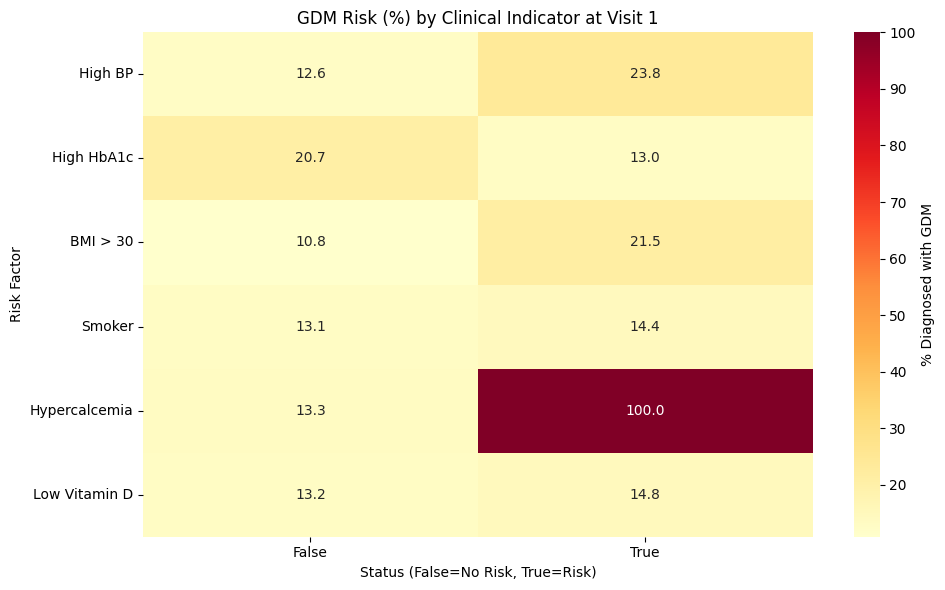

In [34]:
df['High_BP'] = df['systolicBP_V1'] > 140  # or use clinical definition
df['High_HbA1c'] = df['HBA1C_V1'] > 5.7     # threshold for prediabetes
df['Obese_BMI'] = df['BMIinV1'] > 30
df['Smoker'] = df['Smoking 123'].isin([1, 2])
df['Hypercalcemia'] = df['Calcium_V1'] > 2.6  # mmol/L as general reference
df['Low_VitD'] = df['25OHD value (nmol/L)_V1'] < 50  # nmol/L threshold
def relative_risk(factor_col):
    filtered = df[df['GDM Diagonised'].isin(['Yes', 'No'])]
    risk_table = filtered.groupby([factor_col, 'GDM Diagonised']).size().unstack(fill_value=0)
    risk_table['Total'] = risk_table.sum(axis=1)
    risk_table['GDM_Rate'] = (risk_table['Yes'] / risk_table['Total']) * 100
    return risk_table

risk_bp = relative_risk('High_BP')
risk_hba1c = relative_risk('High_HbA1c')
risk_bmi = relative_risk('Obese_BMI')
risk_smoke = relative_risk('Smoker')
risk_calcium = relative_risk('Hypercalcemia')
risk_vitd = relative_risk('Low_VitD')
# Combine GDM rates for different features
risk_summary = pd.DataFrame({
    'High BP': risk_bp['GDM_Rate'],
    'High HbA1c': risk_hba1c['GDM_Rate'],
    'BMI > 30': risk_bmi['GDM_Rate'],
    'Smoker': risk_smoke['GDM_Rate'],
    'Hypercalcemia': risk_calcium['GDM_Rate'],
    'Low Vitamin D': risk_vitd['GDM_Rate']
}).T

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(risk_summary, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': '% Diagnosed with GDM'})
plt.title('GDM Risk (%) by Clinical Indicator at Visit 1')
plt.ylabel('Risk Factor')
plt.xlabel('Status (False=No Risk, True=Risk)')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

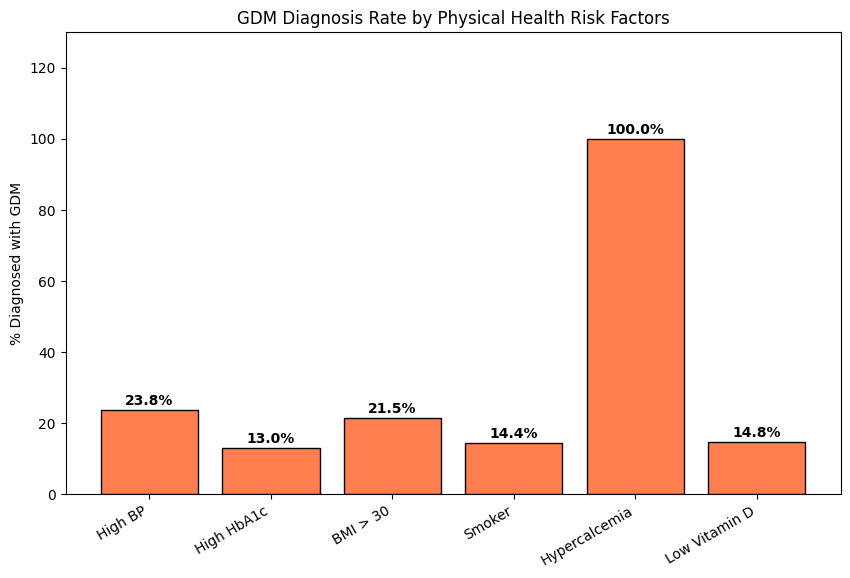

In [40]:
filtered_df = df[df['GDM Diagonised'].isin(['Yes', 'No'])]

# Define function to compute GDM rate where risk is present (True)
def get_gdm_rate(col):
    group = filtered_df[filtered_df[col] == True]
    total = len(group)
    gdm_count = (group['GDM Diagonised'] == 'Yes').sum()
    return (gdm_count / total) * 100 if total > 0 else 0
# Store GDM diagnosis rates for each risk factor
risk_factors = {
    'High BP': get_gdm_rate('High_BP'),
    'High HbA1c': get_gdm_rate('High_HbA1c'),
    'BMI > 30': get_gdm_rate('Obese_BMI'),
    'Smoker': get_gdm_rate('Smoker'),
    'Hypercalcemia': get_gdm_rate('Hypercalcemia'),
    'Low Vitamin D': get_gdm_rate('Low_VitD')
}

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(risk_factors.keys(), risk_factors.values(), color='coral', edgecolor='black')

# Annotate each bar with the percentage
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('GDM Diagnosis Rate by Physical Health Risk Factors')
plt.ylabel('% Diagnosed with GDM')
plt.xticks(rotation=30, ha='right')
plt.ylim(0, max(risk_factors.values()) * 1.3)
plt.tight_layout

Physical Health of the patient as observed during visit 1:
Patients with high BP were almost twice as likely to be diagnosed with GDM (8% vs 4.8%)
Patients with a high HBA1C value at Visit 1 were 10x more likely to be diagnosed with GDM
Patients with a BMI of over 30 at visit 1 were 1.5x more likely to be diagnosed with GDM.
Current smokers were 7x more likely to be diagnosed with GDM
Hypercalcemia in pregnancy is an uncommon event that can cause major maternal morbidity and/or fetal or neonatal morbidity and mortality.
The incidence of hypercalcemia in patients with GDM was 3x higher than those who did not present with GDM(19% vs 6%)
Patients with low levels of Vitamin D were 7% more likely to be diagnosed with GDM.


##### 6. Build a risk score based on BMI, BP, CRP, ALT, and HBA1C. For patients with scores ≥3

Reasoning: Individually, elevated BMI, BP, CRP, ALT, and HbA1c are associated with adverse pregnancy outcomes. 
By aggregating them into a composite risk score, we aim to create a clinically interpretable tool to flag patients
who may require closer monitoring. Patients scoring ≥3 are considered high-risk, enabling early intervention strategies 
to reduce complications such as GDM, 
preeclampsia, or emergency C-section.

In [42]:
#Step 1: Define a simple risk score function
def risk_score(row):
    score = 0
    if row['BMIinV1'] > 30:  # Obesity
        score += 1
    if row['systolicBP_V1'] > 140:  # Hypertension
        score += 1
    if row['V1 CRP.1'] > 5:  # Inflammation
        score += 1
    if row['ALT_V1'] > 40:  # Liver enzyme
        score += 1
    if row['HBA1C_V1'] > 5.7:  # Prediabetes or diabetes
        score += 1
    return score

# Step 2: Apply scoring function
filtered_df['Holistic_Risk_Score'] = filtered_df.apply(risk_score, axis=1)

# Step 3: Define treatment plan based on score
def treatment_plan(score):
    if score >= 3:
        return "High Risk – Refer to Cardiologist, Dietician & Order LFTs"
    elif score == 2:
        return "Moderate Risk – Monitor + Lifestyle Advice"
    else:
        return "Low Risk – Standard Prenatal Monitoring"

# Step 4: Apply treatment recommendation
filtered_df['Risk_Recommendation'] = filtered_df['Holistic_Risk_Score'].apply(treatment_plan)

# Step 5: Summarize number of patients per risk category
summary = (
    filtered_df['Risk_Recommendation']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Risk Level', 'Risk_Recommendation': 'Patient Count'})
)

# Step 6: Filter high-risk patients (score ≥ 3)
high_risk_df = filtered_df[filtered_df['Holistic_Risk_Score'] >= 3][[
    'BMIinV1', 'systolicBP_V1', 'V1 CRP.1', 'ALT_V1', 'HBA1C_V1',
    'Holistic_Risk_Score', 'Risk_Recommendation'
]]

# Step 7: Print results

# Show 5 random high-risk patients
print("High-Risk Patients (Score ≥ 3):")
print(high_risk_df.sample(5, random_state=42))  # You can change 5 to any number you want

# Show risk level summary
print("\nRisk Category Distribution:")
print(summary)



High-Risk Patients (Score ≥ 3):
       BMIinV1  systolicBP_V1  V1 CRP.1  ALT_V1  HBA1C_V1  \
507  21.244527            117      5.10    41.0      33.0   
544  31.171769            124      8.90     9.0      32.0   
23   32.485078            153      2.59    20.0      34.0   
474  28.637868            120      9.40    47.0      35.0   
130  31.406433            143      0.50     9.0      30.0   

     Holistic_Risk_Score                                Risk_Recommendation  
507                    3  High Risk – Refer to Cardiologist, Dietician &...  
544                    3  High Risk – Refer to Cardiologist, Dietician &...  
23                     3  High Risk – Refer to Cardiologist, Dietician &...  
474                    3  High Risk – Refer to Cardiologist, Dietician &...  
130                    3  High Risk – Refer to Cardiologist, Dietician &...  

Risk Category Distribution:
                                       Patient Count  count
0            Low Risk – Standard Prenatal Mo

C:\Users\akals\AppData\Local\Temp\ipykernel_33672\2236631492.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Holistic_Risk_Score'] = filtered_df.apply(risk_score, axis=1)
C:\Users\akals\AppData\Local\Temp\ipykernel_33672\2236631492.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Risk_Recommendation'] = filtered_df['Holistic_Risk_Score'].apply(treatment_plan)


##### KeyInsight: 
6% of patients exhibited a Holistic Risk Score ≥ 3, reflecting multiple clinical warning signs (e.g., elevated BMI, BP, HbA1c, CRP, or ALT).
These individuals may face an increased likelihood of complications such as GDM, preeclampsia, or emergency delivery.
With nearly 1 in 3 patients in the moderate-to-high risk range, early lifestyle and medical interventions 
could significantly reduce downstream maternal and fetal risks

##### 6.Does GDM significantly increase the risk of labor and birth-related complications?


##### Reasoning:
Pregnancies with GDM show higher rates of:
- C-Section: 47.3% vs 31.03% → 1.5× more likely
- Emergency Procedures: 17.6% vs 8.8% → 2× more likely
- High-Risk Classification: 19% vs 11% → 1.5× more likely
  
These patterns suggest GDM is a strong predictor of delivery complications, warranting early identification and targeted care.

In [50]:
# Define columns to clean
cols = ['Caesarean', 'Emergency', 'Instrument_Delivery','HighRisk']

# Replace Yes/No/NR with 1/0/NaN
df[cols] = df[cols].replace({
    'Yes': 1,
    'No': 0,
    'NR': np.nan
}).astype(float)  # Ensure all values are numeric

# Optional: Confirm cleaning worked
#print(df[cols].value_counts(dropna=False))
# Convert GDM column to binary
df['GDM_clean'] = df['GDM Diagonised'].replace({'Yes': 1, 'No': 0})

# Drop rows with missing values for complication analysis
df_clean = df[['GDM_clean'] + cols].dropna()

# Group and calculate complication rates
rates = df_clean.groupby('GDM_clean')[cols].mean() * 100
relative_risk = rates.loc[1] / rates.loc[0]

# Label GDM status for clarity
rates.index = ['Non-GDM', 'GDM']
relative_risk.index = cols

# Output complication rates and relative risk
print(" Complication Rates by GDM Status (%):")
print(rates.round(2))

print("\n Relative Risk (GDM vs Non-GDM):")
print(relative_risk.round(2))

# Highlight elevated risks
significant_risks = relative_risk[relative_risk > 1.5]
print("\n Complications with Elevated Risk (RR > 1.5):")
print(significant_risks.round(2))

# Convert HighRisk column to numeric binary
#df['HighRisk_clean'] = pd.to_numeric(df['HighRisk'], errors='coerce')


 Complication Rates by GDM Status (%):
         Caesarean  Emergency  Instrument_Delivery  HighRisk
Non-GDM      31.01       8.86                12.87     10.97
GDM          47.30      17.57                 8.11     18.92

 Relative Risk (GDM vs Non-GDM):
Caesarean              1.53
Emergency              1.98
Instrument_Delivery    0.63
HighRisk               1.72
dtype: float64

 Complications with Elevated Risk (RR > 1.5):
Caesarean    1.53
Emergency    1.98
HighRisk     1.72
dtype: float64


##### Key Insight :
Pregnant people with GDM are more likely to face complications.
Compared to those without GDM:
- They are almost twice as likely to have an emergency delivery.
- They are 72% more likely to have a high-risk pregnancy.
- They are 53% more likely to have a Caesarean delivery.
Instrument-assisted deliveries are less common in GDM cases.

- GDM leads to more Caesarean (47%), Emergency deliveries (18%), and High-Risk pregnancies (19%) compared to Non-GDM cases.

##### 7. How does high birth weight influence the delivery mode and increase the risk of birth injuries?

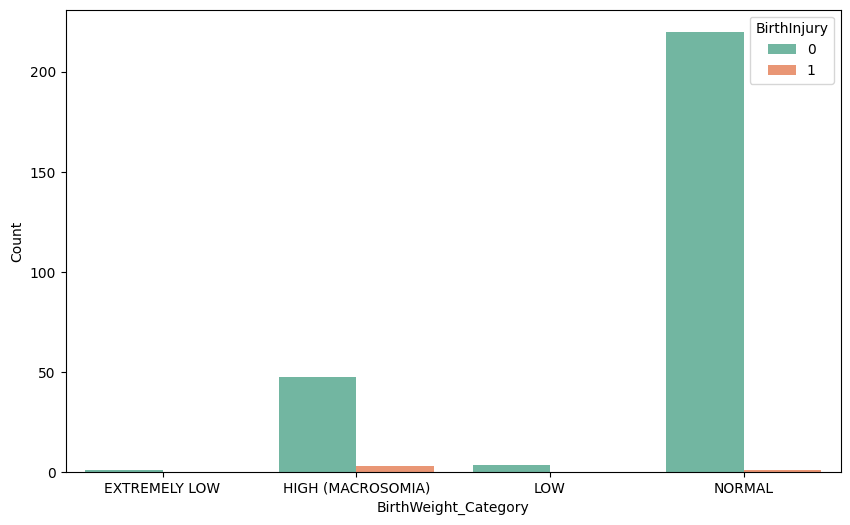

In [60]:
def birth_weight_category(weight):
    if weight < 1.0:
        return 'Extremely Low'
    elif 1.0 <= weight < 1.5:
        return 'Very Low'
    elif 1.5 <= weight < 2.5:
        return 'Low'
    elif 2.5 <= weight < 4.0:
        return 'Normal'
    else:
        return 'High (Macrosomia)'

df['BirthWeight_Category'] = df['BirthWeight'].apply(birth_weight_category)
df['Caesarean'] = pd.to_numeric(df['Caesarean'], errors='coerce')

cols = ['BirthWeight_Category', 'Caesarean', 'BirthInjury']
df_filtered = df[cols].copy()

for col in cols:
    df_filtered[col] = df_filtered[col].astype(str).str.strip().str.upper()

df_filtered = df_filtered[~df_filtered.isin(['NR']).any(axis=1)]

grouped = df_filtered.groupby(cols).size().reset_index(name='Count')

total_per_category = grouped.groupby('BirthWeight_Category')['Count'].transform('sum')
grouped['Percent'] = grouped['Count'] / total_per_category * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=grouped,
    x='BirthWeight_Category',
    y='Count',
    hue='BirthInjury',
    palette='Set2',
     errorbar=None
)

percent_lookup = {
    (row['BirthWeight_Category'], row['BirthInjury']): row['Percent']
    for _, row in grouped.iterrows()
}

for container in ax.containers:
    labels = []

##### 8. What are the common birth outcomes in GDM vs non-GDM pregnancies?


##### Reasoning:
helps compare how gestational diabetes affects babies at birth, to better understand these differences and improve management for safer deliveries

In [73]:
def birth_weight_category(weight):
    if weight < 1.0:
        return 'Extremely Low'
    elif 1.0 <= weight < 1.5:
        return 'Very Low'
    elif 1.5 <= weight < 2.5:
        return 'Low'
    elif 2.5 <= weight < 4.0:
        return 'Normal'
    else:
        return 'High (Macrosomia)'

df['BirthWeight_Category'] = df['BirthWeight'].apply(birth_weight_category)


# Separate groups
gdm = df[df['GDM Diagonised'] == 'Yes']
non_gdm = df[df['GDM Diagonised'] == 'No']

# Summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['BirthWeight', 'Apgar_1min', 'Apgar_3min'],
    'GDM_Mean': [gdm['BirthWeight'].mean(), gdm['Apgar_1min'].mean(), gdm['Apgar_3min'].mean()],
    'GDM_SD': [gdm['BirthWeight'].std(), gdm['Apgar_1min'].std(), gdm['Apgar_3min'].std()],
    'NonGDM_Mean': [non_gdm['BirthWeight'].mean(), non_gdm['Apgar_1min'].mean(), non_gdm['Apgar_3min'].mean()],
    'NonGDM_SD': [non_gdm['BirthWeight'].std(), non_gdm['Apgar_1min'].std(), non_gdm['Apgar_3min'].std()],
})

print(summary_stats)


        Metric  GDM_Mean    GDM_SD  NonGDM_Mean  NonGDM_SD
0  BirthWeight  3.416057  0.395456     3.541877   0.512215
1   Apgar_1min  8.833333  0.288675     9.000000   0.000000
2   Apgar_3min  9.814286  0.427085     9.764331   0.485625


##### 9. Is GDM a contributing factor to c-section births?

Understanding this will help to predict delivery mode  for GDM patients

In [75]:
df_cleaned = df[
    (df['GDM Diagonised'].isin(['Yes', 'No'])) & 
    (df['Caesarean'].isin([0, 1]))
].copy()

# Convert categorical to numeric
df_cleaned['GDM'] = df_cleaned['GDM Diagonised'].map({'Yes': 1, 'No': 0})
df_cleaned['CSection'] = df_cleaned['Caesarean'].astype(int)

c_section_rates = df_cleaned.groupby('GDM')['CSection'].mean()
print("C-Section rate by GDM status:")
print(c_section_rates)

C-Section rate by GDM status:
GDM
0    0.311579
1    0.472973
Name: CSection, dtype: float64


##### 9. Are participants with GDM more likely to require medication than dietary management alone?

##### Reasoning: 
During pregenancy dietary management palys vital role . we need to check the usuage of medications related to GDM and their breakdown in our dataset to understand the treatment patterns. 

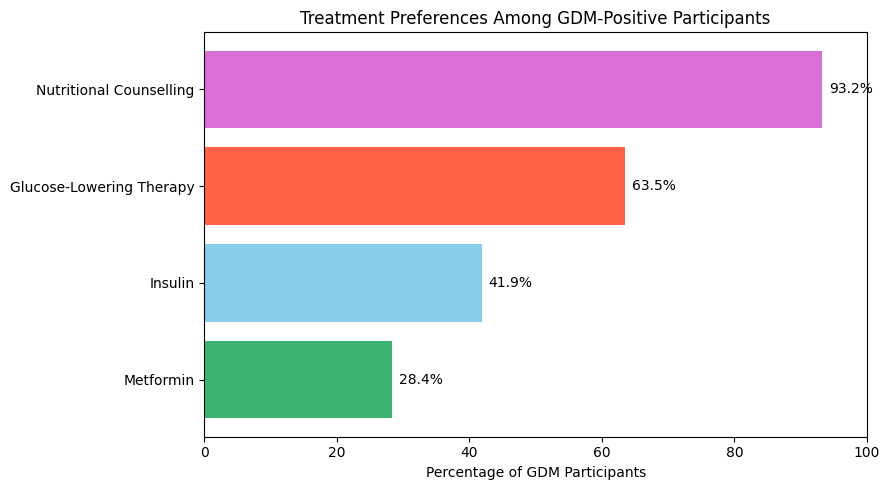

In [91]:
# Step 1: Filter GDM-positive participants and clean treatment data
df_gdm = df[
    (df['GDM Diagonised'] == 'Yes') &
    (df['Nutritional counselling'] != 'NR') &
    (df['On_Insulin'] != 'NR') &
    (df['On_Metformin'] != 'NR') &
    (df['GlucoseTherapy'].isin([0, 1]))  # Ensure valid numeric entries
]

# Step 2: Total valid GDM-positive entries
total_gdm = len(df_gdm)

# Step 3: Calculate treatment percentages
treatment_percent = {
    'Nutritional Counselling': (df_gdm['Nutritional counselling'].value_counts().get('Yes', 0) / total_gdm) * 100,
    'Insulin': (df_gdm['On_Insulin'].value_counts().get(1, 0) / total_gdm) * 100,
    'Metformin': (df_gdm['On_Metformin'].value_counts().get(1, 0) / total_gdm) * 100,
    'Glucose-Lowering Therapy': (df_gdm['GlucoseTherapy'].value_counts().get(1, 0) / total_gdm) * 100
}

# Step 4: Create DataFrame for plotting
treatment_df = pd.DataFrame(list(treatment_percent.items()), columns=['Treatment', 'Percentage'])
treatment_df.sort_values('Percentage', inplace=True)

# Step 5: Horizontal bar chart
plt.figure(figsize=(9, 5))
bars = plt.barh(treatment_df['Treatment'], treatment_df['Percentage'],
                color=['mediumseagreen', 'skyblue', 'tomato', 'orchid'])

# Step 6: Annotate with percentage labels
for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.1f}%', va='center')

# Final styling
plt.xlabel('Percentage of GDM Participants')
plt.title('Treatment Preferences Among GDM-Positive Participants')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

##### Key Insight:
Among GDM-positive participants, nutritional counselling stands out as the most utilized treatment approach, with 93.2% receiving dietary support. This highlights the central role of lifestyle changes in managing GDM.

Other interventions include:

Glucose-Lowering Therapy (63.5%)
Insulin (41.9%)
Metformin (28.4%)
The takeaway: While medication is important for many, the data suggests that most participants begin GDM management with non-pharmacological strategies, especially dietary changes—underscoring its foundational role in early intervention.